# 기본 필요 라이브러리

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import requests
import os
from glob import glob
import io
import numpy as np
from io import BytesIO

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max.colwidth',100)
pd.options.display.max_columns = 100

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1. 데이터 불러오기 


In [2]:
df = pd.read_csv('real_train.csv',encoding='utf-8-sig')
df.head()
df.shape

,Unnamed: 0,video_name,thumbnail,category_id
0,3801,100평인데 50평밖에 쓸 수 없는 땅 판별법,https://i.ytimg.com/vi/tBckTO0QzQo/hqdefault.jpg?sqp=-oaymwEZCNACELwBSFXyq4qpAwsIARUAAIhCGAFwAQ=...,1
1,21501,실화!? 김메주네 집에 초대받은 랜선집사들!,https://i.ytimg.com/vi/6F18gZd0gio/hqdefault.jpg?sqp=-oaymwEZCNACELwBSFXyq4qpAwsIARUAAIhCGAFwAQ=...,4
2,20787,물에빠지더니 극소심해진 삼색이,https://i.ytimg.com/vi/eOb17B2xyc4/hqdefault.jpg?sqp=-oaymwEZCNACELwBSFXyq4qpAwsIARUAAIhCGAFwAQ=...,4
3,11241,듣기 싫은 꼰대어 월드컵,https://i.ytimg.com/vi/ipHmQUOgKeA/hqdefault.jpg?sqp=-oaymwEZCNACELwBSFXyq4qpAwsIARUAAIhCGAFwAQ=...,2
4,31868,VLOG::여름대비 몸만들기::토끼와 거북이 이야기가 주는 교훈::멈추지 않는것이 중요하다,https://i.ytimg.com/vi/r_3wfUlmt2A/hqdefault.jpg?sqp=-oaymwEZCNACELwBSFXyq4qpAwsIARUAAIhCGAFwAQ=...,6


(11199, 4)

In [3]:
category = df['category_id']
thumbnail = df['thumbnail']

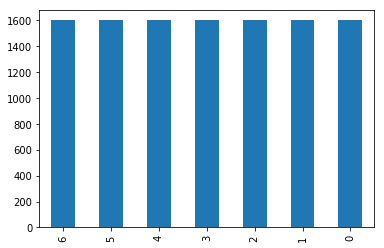

In [4]:
category.value_counts().plot.bar()

In [5]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

Using TensorFlow backend.


- 밑에 저장한 파일 있으니, 돌리지말고 쓰기
- image_train_test_split.npy

In [65]:
image_w = 64 
image_h = 64
pixels = image_w * image_h * 3
X = []
for i in thumbnail :
    
    url = i+str('.jpg')
    response = requests.get(url, stream=True) 
    img= Image.open(io.BytesIO(response.content)) 
    
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    img = image.img_to_array(img)

#     # 데이터를 전처리합니다(채널별 컬러 정규화를 수행합니다)
    img = preprocess_input(img)
    X.append(img)

In [66]:
X = np.array(X)
Y = np.array(category)
Y = pd.get_dummies(Y).to_numpy()

In [67]:
X.shape
Y.shape

(11199, 64, 64, 3)

(11199, 7)

In [69]:
np.save('total_train_X_imgs',X)

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, Y)
xy = (X_train, X_test, y_train, y_test)
np.save("image_train_test_split.npy", xy)
print("ok,", len(Y))

ok, 11199


# 데이터 다시 열고 확인

In [6]:
# !pip install numpy==1.16.1
import numpy as np

In [7]:
# 데이터 열기 

# 혹시 ValueError: Object arrays cannot be loaded when allow_pickle=False => !pip install numpy==1.16.1
X_train, X_valid, y_train, y_valid = np.load("image_train_test_split.npy", allow_pickle=True)

In [8]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((8399, 64, 64, 3), (2800, 64, 64, 3), (8399, 7), (2800, 7))

- 이미지 확인해보기

In [0]:
for i in range(3):
    plt.figure()
    plt.imshow(X_train[i]/256)
    plt.show()

# CNN_Sequential

In [9]:
# 카테고리 지정하기
categories = category.unique()
nb_classes = len(categories)
# 이미지 크기 지정하기
image_w = 64
image_h = 64

# 데이터 정규화하기(0~1사이로)
X_train = X_train.astype("float") / 64 # 256 으로 하면?
X_valid  = X_valid.astype("float")  / 64
print('X_train shape:', X_train.shape) # 74%
print('X_valid shape:', X_valid.shape)


X_train shape: (8399, 64, 64, 3)
X_valid shape: (2800, 64, 64, 3)


In [10]:
from keras.models import Sequential
from keras import metrics
from keras import optimizers
from keras.layers import MaxPooling2D
from keras.layers import Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
import numpy as np
import os

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3))) #전체 train에 돌릴때는 32로
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
last_layer = model.add(Dropout(0.25))

# 전결합층
model.add(Flatten())    # 벡터형태로 reshape
model.add(Dense(512))   # 출력
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))
# 모델 구축하기
model.compile(loss='categorical_crossentropy',   # 최적화 함수 지정
    optimizer='rmsprop',
    metrics=['accuracy'])

# 모델 요약
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 64)      

C:\Users\LG\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.



Train on 8399 samples, validate on 2800 samples
Epoch 1/15
8399/8399 [==============================] - 189s 23ms/step - loss: 1.8143 - accuracy: 0.4371 - val_loss: 1.3451 - val_accuracy: 0.5339
Epoch 2/15
8399/8399 [==============================] - 184s 22ms/step - loss: 1.1460 - accuracy: 0.5980 - val_loss: 1.0762 - val_accuracy: 0.6064
Epoch 3/15
8399/8399 [==============================] - 149s 18ms/step - loss: 0.9630 - accuracy: 0.6602 - val_loss: 0.9641 - val_accuracy: 0.6607
Epoch 4/15
8399/8399 [==============================] - 146s 17ms/step - loss: 0.7982 - accuracy: 0.7188 - val_loss: 0.9077 - val_accuracy: 0.6854
Epoch 5/15
8399/8399 [==============================] - 159s 19ms/step - loss: 0.6530 - accuracy: 0.7745 - val_loss: 0.8910 - val_accuracy: 0.6975
Epoch 6/15
8399/8399 [==============================] - 146s 17ms/step - loss: 0.5321 - accuracy: 0.8119 - val_loss: 1.0296 - val_accuracy: 0.6804
Epoch 7/15
8399/8399 [==============================] - 148s 18ms/ste

(0, 1)

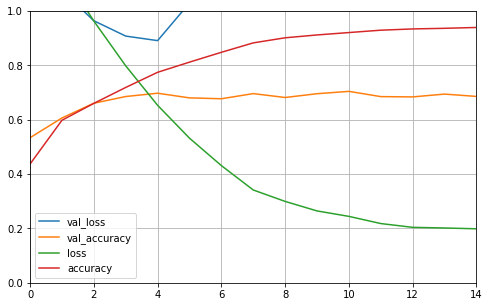

In [14]:
history1 = model.fit(X_train, y_train, batch_size=32, nb_epoch=15 , validation_data=(X_valid, y_valid)) # 

pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [15]:
# 모델 평가하기 
score = model.evaluate(X_valid, y_valid)
print('loss=', score[0])        # loss
print('accuracy=', score[1])    # acc

2800/2800 [==============================] - 15s 5ms/step
loss= 1.8611263908658708
accuracy= 0.6857143044471741


In [16]:
pred_valid = np.argmax(model.predict(X_valid), axis=-1)
true_valid = [np.where(r==1)[0][0] for r in y_valid]

In [17]:
pred_valid,
true_valid

(array([3, 4, 4, ..., 3, 0, 5], dtype=int64),)

[2,
 4,
 4,
 3,
 3,
 0,
 2,
 1,
 0,
 4,
 4,
 2,
 4,
 6,
 6,
 6,
 2,
 4,
 1,
 1,
 1,
 4,
 0,
 2,
 3,
 6,
 1,
 2,
 6,
 0,
 0,
 5,
 2,
 3,
 4,
 4,
 3,
 5,
 5,
 5,
 0,
 1,
 4,
 0,
 0,
 2,
 2,
 5,
 6,
 3,
 1,
 6,
 1,
 4,
 3,
 3,
 3,
 5,
 3,
 5,
 0,
 4,
 1,
 3,
 0,
 5,
 2,
 1,
 1,
 3,
 6,
 3,
 1,
 0,
 5,
 0,
 0,
 4,
 5,
 6,
 2,
 2,
 4,
 4,
 3,
 5,
 5,
 6,
 1,
 1,
 3,
 0,
 6,
 0,
 4,
 2,
 4,
 2,
 4,
 0,
 1,
 0,
 2,
 1,
 1,
 1,
 3,
 2,
 4,
 2,
 0,
 6,
 0,
 2,
 5,
 5,
 3,
 2,
 0,
 6,
 0,
 5,
 2,
 6,
 3,
 6,
 0,
 6,
 3,
 4,
 3,
 1,
 3,
 6,
 1,
 6,
 1,
 6,
 6,
 2,
 5,
 0,
 4,
 1,
 0,
 4,
 4,
 2,
 2,
 6,
 1,
 3,
 4,
 3,
 2,
 2,
 0,
 4,
 4,
 0,
 6,
 3,
 3,
 6,
 2,
 1,
 6,
 4,
 1,
 0,
 6,
 5,
 0,
 5,
 4,
 0,
 1,
 5,
 4,
 3,
 1,
 4,
 0,
 0,
 1,
 0,
 3,
 0,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 1,
 1,
 2,
 1,
 5,
 6,
 5,
 0,
 1,
 1,
 0,
 2,
 4,
 0,
 2,
 0,
 6,
 2,
 1,
 0,
 4,
 3,
 1,
 3,
 3,
 4,
 1,
 5,
 2,
 0,
 1,
 1,
 2,
 3,
 4,
 3,
 2,
 5,
 2,
 5,
 6,
 0,
 6,
 2,
 6,
 3,
 2,
 6,
 5,
 6,
 3,
 4,
 2,
 1,
 4,


In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [24]:
print(classification_report(true_valid, pred_valid))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       418
           1       0.79      0.84      0.81       403
           2       0.54      0.46      0.50       381
           3       0.57      0.73      0.64       377
           4       0.64      0.84      0.73       405
           5       0.80      0.68      0.73       389
           6       0.76      0.43      0.55       427

   micro avg       0.69      0.69      0.69      2800
   macro avg       0.69      0.69      0.68      2800
weighted avg       0.69      0.69      0.68      2800



In [22]:
y_true = pd.Series(true_valid)
y_pred = pd.Series(pred_valid)

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'])

Predicted,0,1,2,3,4,5,6
True,,,,,,,
0,340,5,9,11,46,2,5
1,10,337,15,19,11,6,5
2,34,21,176,57,36,30,27
3,17,14,20,277,31,8,10
4,18,4,8,23,341,5,6
5,10,26,32,38,12,264,7
6,31,17,63,57,58,16,185


- 모델 불러오기

In [31]:
from keras.models import model_from_json   
json_file = open("seq_model_81.json", "r")   
loaded_model_json = json_file.read()   
json_file.close()   
loaded_model = model_from_json(loaded_model_json)  

- test
- 게임같은건 진짜 게임으로 분류하는데

In [17]:
image_w = 64 
image_h = 64
pixels = image_w * image_h * 3

i = "https://i.ytimg.com/vi/zqXKj8A5Nsw/hqdefault.jpg?sqp=-oaymwEZCNACELwBSFXyq4qpAwsIARUAAIhCGAFwAQ==&amp;rs=AOn4CLBVKGeAvOXF3LIxv-gHm7JXCty6BA"
url = i+str('.jpg')
response = requests.get(url, stream=True) 
test_img= Image.open(io.BytesIO(response.content)) 
    
test_img = test_img.convert("RGB")
test_img = test_img.resize((image_w, image_h))
test_img = image.img_to_array(test_img)

 # 데이터를 전처리합니다(채널별 컬러 정규화를 수행합니다)
test_img = preprocess_input(test_img)
test_img = test_img.astype("float") / 256
test_img = test_img.reshape(-1, 64, 64,3)

In [18]:
# 예측
pred = model.predict(test_img)  
result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
print('data category : ',categories[result[0]])
# category ( 0: cooking , 1: economy, 2: game, 3: movie, 4: pets, 5: sports)

data category :  2


In [ ]:
<img id="img" class="style-scope yt-img-shadow" alt="" width="246" src="https://i.ytimg.com/vi/BmDT1eq23l4/hqdefault.jpg?sqp=-oaymwEZCNACELwBSFXyq4qpAwsIARUAAIhCGAFwAQ==&amp;rs=AOn4CLAuNtF1J_P6ZCCQRFTEt2rTcTdv0g">

- 학습 완료된 모델 저장

In [19]:
# 학습 완료된 모델 저장
seq_model_81_json = model.to_json()
with open("seq_model_81.json", "w") as json_file : 
    json_file.write(seq_model_81_json)
model.save_weights("seq_model_81.h5")
print("Saved model to disk")

4611

Saved model to disk


- 저장된 모델 가져오기

In [0]:
# from keras.models import model_from_json   
# json_file = open("model.json", "r")   
# loaded_model_json = json_file.read()   
# json_file.close()   
# loaded_model = model_from_json(loaded_model_json)  